# Predicting Seasonal Influenza: How Do RNNs Compare to Traditional Methods?

In the time of COVID-19, the need for accurate predictions of both long-term and short-term behavior of epidemics has been made apparent. In order to determine which methods may be most useful in making predictions, we first aim to study a similar virus with more robust data.

The Centers for Disease Control and Prevention (CDC) has surveillence systems in place for tracking the seasonal spread of influenza. One such network is the US Outpaitent Influenza-like Illness Surveillance Network (ILINet). Each week, outpatient healthcare providers in ILINET report 
- The total number of patients seen for any reason
- The number of those patients with influenza-like illness (ILI) by age group

ILI is defined by
- Fever
- Cough and/or sore throat with out a known cause other than flu

ILINet provides data on a national, state, and regional level as well as percentages of visits due to ILI weighted by population and unweighted. We will be looking at the national level data for weekly case counts.

We will compare predictions of seasonal influenza from SIR models with Recurrent Neural Networks, Long Short Term Memory networks (LSTMs) and Seq2Seq networks, on this data.

# Loading the data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full_seasons =ilinet_full[0:782] #ignoring current season for now
data = ilinet_full_seasons['ILITOTAL'].values
weeks = ilinet_full_seasons['WEEK'].values[0:52]
plt.plot(data)
plt.title("ILINet Data 2004-2019")
plt.ylabel("Number of Patients for ILI")
plt.show()

<Figure size 640x480 with 1 Axes>

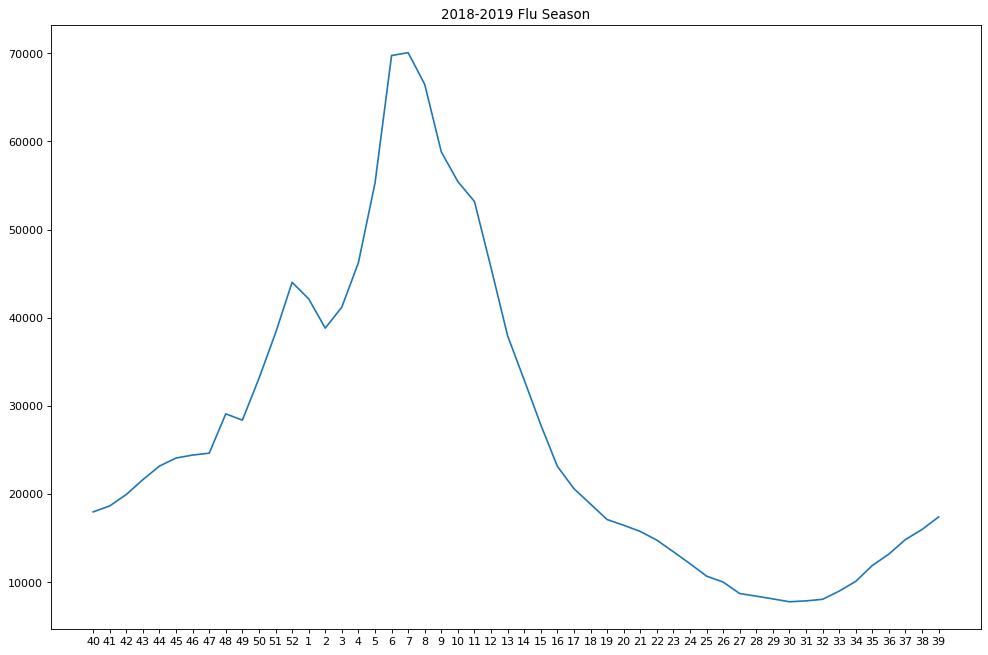

In [2]:
import numpy as np
# format data to be seasonal
end_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 39].tolist()
start_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 40].tolist()

seasons=[]
for i in range(len(start_weeks)):
    c=start_weeks[i]
    seasons.append(data[c:c+52])
    
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(seasons[-1])
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.title("2018-2019 Flu Season")
seasons=np.vstack(seasons)

We can see that influenza epidemics follow a similar pattern. Furthermore, we can see that 
- We are dealing with time-series data
- Most seasons are similar to the previous season.

Therefore, it is likely that RNNs would work well with this data. However, we first look at a traditional method for studying epidemics, the SIR model.

# The SIR Model

The SIR model is a system of ordinary differential equations (ODEs) that divide the population into three groups: Susceptible, Infected, and Recovered. A flow diagram of this model can be seen below.
![title](SIRmodel.png)
In this model, susceptibles become infected with rate $\beta$, and infected recover with rate $\gamma$.

In order to use the SIR model to make predictions, we must optimize the parameters of the model to fit the data. The parameters we optimize include
- % of the population that is initially susceptible
- $\beta$: rate of infection
- $\gamma$: rate of recovery.

In [3]:
from scipy.integrate import odeint
from scipy import optimize

# The SIR model differential equations.
def sir_model(y, t, params):
    S, I, R = y
    dSdt = -params[1] * S * I / (params[0]*N)
    dIdt = params[1] * S * I / (params[0]*N) - params[2] * I
    dRdt = params[2] * I
    return (dSdt, dIdt, dRdt)

def run_model(init, p):
    f = lambda y,t: sir_model(y, t, p)
    y0 = p[0]*N, init, 0
    sol = odeint(f, y0, t)
    S, I, R = sol.T
    return S, I, R,t

def error_fn(real,model):
    error = real-model
    # Since the peak week of a epidemic is an important feature, 
    # we want to make sure this value is accurate
    error[np.argmax(real)]=error[np.argmax(real)]*1000
    return error

def real_mod_comp(p,real):
    modelS,modelI,modelR,t = run_model(real[0], p)
    err=error_fn(real,modelI)
    # we want to make sure our parameters are biologically plausible
    if p[0]<0 or p[1]<0 or p[2]<0 or p[0]>1:
        err = err+10**6
    return err

First, we look at making predictions based on the previous season.

We optimize the model parameters to fit the previous season and then use these parameters to run the model and compare the real data.

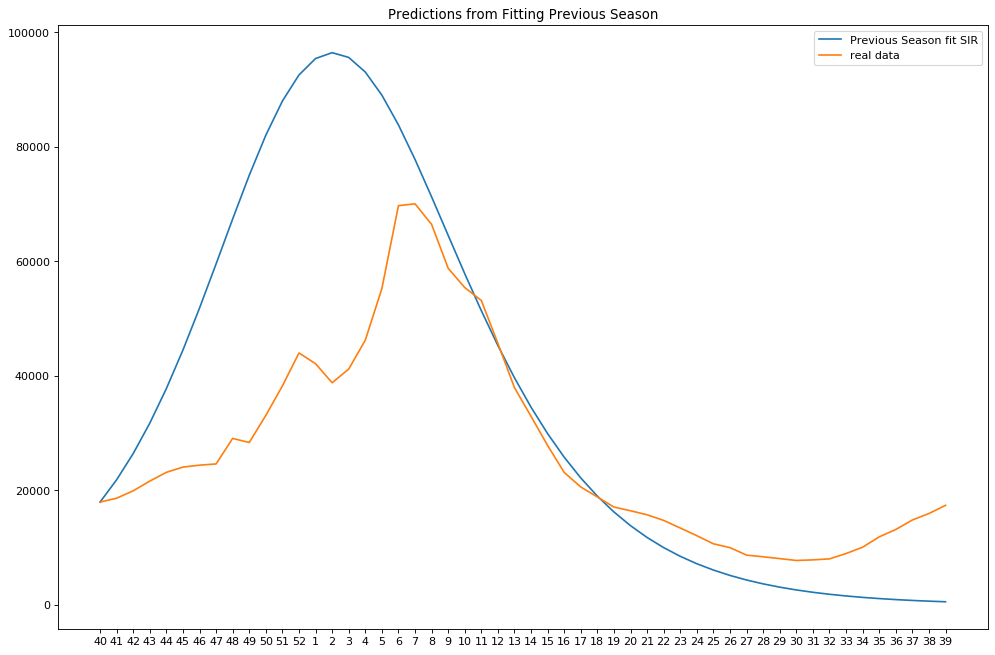

In [4]:
import warnings
warnings.filterwarnings("ignore")

N=300000000 #approximate US pop.
t = np.linspace(0, 52, 52)
p0=[.5,.7, 1./14]

#get parameters from fitting to last season
fn = lambda p: real_mod_comp(p,seasons[-2])
(c,kvg) = optimize.leastsq(fn, p0) 
p_prev=c

S,I,R,t=run_model(seasons[-1][0], p_prev)

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)

plt.plot(I, label="Previous Season fit SIR", linestyle='-')
plt.plot(seasons[-1],label="real data")
plt.title("Predictions from Fitting Previous Season")
plt.legend()
plt.show()

Next, we see how the SIR model does making predictions from only 10 data points. 

We will do this in two ways
- Fitting to the previous season and using these parameters as a starting point for optimization

- Using a general starting point


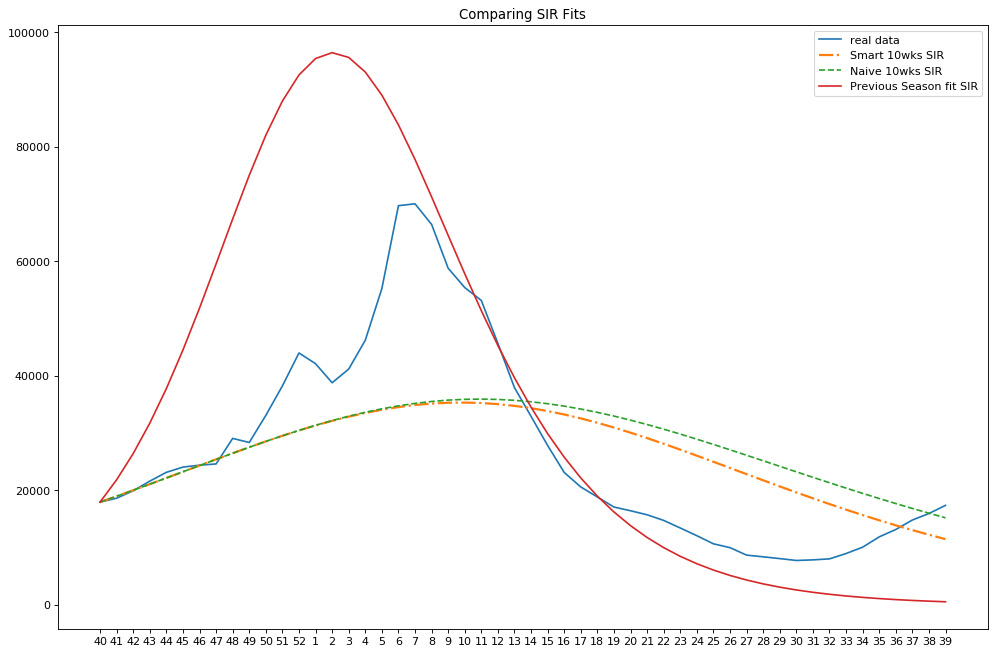

In [5]:
def error_fn_partial(real,model):
    error = real-model
    error[-1]= error[-1]*100 #weight last data point
    return error
def run_model_partial(init, p):
    f = lambda y,t: sir_model(y, t, p)
    y0 = p[0]*N, init, 0
    ret = odeint(f, y0, t)
    S, I, R = ret.T
    return I,t
def real_mod_comp_partial(p,real):
    c=0
    if p[0]<0 or p[1]<0 or p[2]<0:
        c = 10**10
    model,t = run_model_partial(real[0], p)
    err=error_fn_partial(real,model)+c
    return err

N=300000000
p0=[.5,.7, 1./14]

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1],label="real data")

numwks=10
t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp_partial(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p_prev) 

t = np.linspace(0, 52, 52)
S,I2,R,t=run_model(seasons[-1][0], c)
plt.plot(I2, label="Smart 10wks SIR", linestyle='-.', linewidth =2)

t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp_partial(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p0) 

t = np.linspace(0, 52, 52)
S,I3,R,t=run_model(seasons[-1][0], c)
plt.plot(I3, label="Naive 10wks SIR", linestyle='--')
plt.legend()

plt.plot(I, label="Previous Season fit SIR", linestyle='-')
plt.title("Comparing SIR Fits")
plt.legend()
plt.show()

We can see that the the SIR model does not make accurate predictions.

The best long-term predictions we could achieve from the SIR model came from fitting the model to the previous seasons data.   

The best short-term predictions we could achieve from the SIR model came from the "smart" partial fit. 

# LSTM Network

Now, we turn to RNNs. Since we are trying to predict time series data, we will use long short-term memory networks, which are well suited for this task.

This implementation of an LSTM is adapted from the tutorial

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

The first step in implementing the LSTM model is to normalize the data. 

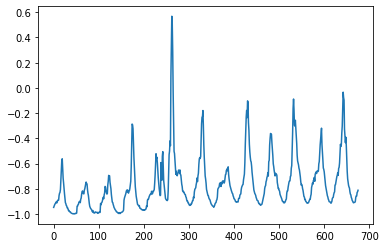

In [6]:
import torch
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
maxval = seasons.max()
minval = seasons.min()
scaleddata = scaler.fit_transform(seasons[0:-1].reshape(-1, 1))
full_data = torch.FloatTensor(scaleddata).view(-1)
train_data = full_data[:-52] #removing last season from training data
plt.plot(train_data)
plt.show()

Next, we create tuples that will be used to train the model. These tuples will contain 52 week of data as the input and the following week as the output.

In [7]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)

An example of the input/output sequence is given below.

In [8]:
print(train_inout_seq[0])

(tensor([-0.9482, -0.9377, -0.9287, -0.9207, -0.9165, -0.9069, -0.9065, -0.9128,
        -0.8968, -0.8963, -0.8888, -0.8903, -0.8537, -0.8362, -0.8297, -0.8065,
        -0.7353, -0.6486, -0.5755, -0.5625, -0.6385, -0.7166, -0.7542, -0.8025,
        -0.8394, -0.8756, -0.9104, -0.9189, -0.9332, -0.9373, -0.9524, -0.9519,
        -0.9630, -0.9739, -0.9729, -0.9811, -0.9841, -0.9838, -0.9899, -0.9936,
        -0.9948, -0.9966, -0.9984, -0.9986, -0.9977, -0.9999, -1.0000, -0.9974,
        -0.9968, -0.9976, -0.9932, -0.9935]), tensor([-0.9387]))


Now we construct the model.

In [9]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [10]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We train the model on the input/output sequences we created earlier and look at the loss.

In [11]:
epochs = 50
losses=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        losses.append(single_loss)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01020953
epoch:  26 loss: 0.00540630
epoch:  49 loss: 0.0000461929


29

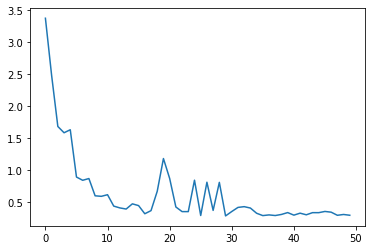

In [12]:
losses=[float(i) for i in losses]
lossperepoch  =[]
sep=int(len(losses)/epochs)
c=0
for i in range(0,len(losses),sep):
    lossperepoch.append(sum(losses[c*sep:c*sep+sep]))
    c=c+1
plt.plot(range(0,epochs),np.log(lossperepoch))
np.argmin(lossperepoch)

Since it looks like the model converges, but the loss it pretty high. Lets see what the predictions for the next season look like.

In [13]:
fut_pred = 52

test_inputs = full_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])

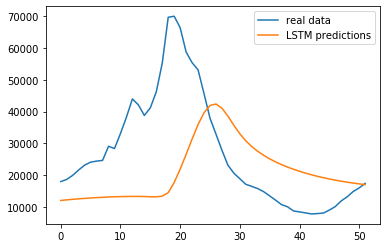

In [14]:
unscaled = scaler.inverse_transform(actual_predictions.reshape(-1, 1))
unscaled
plt.plot(seasons[-1], label='real data')
plt.plot(unscaled, label='LSTM predictions')
plt.legend()
plt.show()

There predictions aren't great! Let's see how they compare to the SIR model.

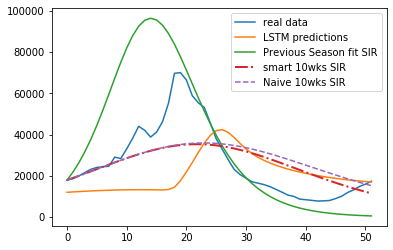

In [15]:
plt.plot(seasons[-1], label='real data')
plt.plot(unscaled, label='LSTM predictions')
plt.plot(I, label="Previous Season fit SIR", linestyle='-')
plt.plot(I2, label="smart 10wks SIR", linestyle='-.', linewidth =2)
plt.plot(I3, label="Naive 10wks SIR", linestyle='--')
plt.legend()
plt.show()

In [16]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I) - np.argmax(seasons[-1])))

Difference in Peak Value:
LSTM Predictions: 27646.726872302585
Best SIR Prediction: 26391.165019990673

Difference in Peak Week:
LSTM Predictions: 7
Best SIR Prediction: 5


This is actually doing worse than the SIR model!

However, we can see that it may be able to fit the shape better. Therefore, we want to see if a more sophisticated RNN will do a better job.

# Seq2Seq Model

The implementation of this model is adapted from 

https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb

In [17]:
normalized_seasons=(seasons-seasons.min())/(seasons.max()-seasons.min())

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam


latent_dim = 50 # LSTM hidden units
dropout = .20 

encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 1)) 

decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) 
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [18]:
def transform_series_encode(series_array):
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array #- series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = series_array - np.zeros([len(encode_series_mean),1])#encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [19]:
encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [20]:
batch_size = 2**11
epochs = 100

encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2] 
                                            
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2);

Instructions for updating:
Use tf.cast instead.
Train on 10 samples, validate on 3 samples
Epoch 1/100
10/10 [==============================] - 1s 72ms/step - loss: 0.2525 - val_loss: 0.2311
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2284 - val_loss: 0.2077
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1987 - val_loss: 0.1834
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1836 - val_loss: 0.1632
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1701 - val_loss: 0.1557
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1553 - val_loss: 0.1532
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1743 - val_loss: 0.1522
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1646 - val_loss: 0.1514
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1633 - val_loss: 0.1500
Epoch 10/100
10/1

10/10 [==============================] - 0s 5ms/step - loss: 0.0533 - val_loss: 0.0475
Epoch 81/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0467
Epoch 82/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0499 - val_loss: 0.0461
Epoch 83/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0468 - val_loss: 0.0471
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0466
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0470 - val_loss: 0.0437
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0441 - val_loss: 0.0434
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0487 - val_loss: 0.0438
Epoch 88/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0488 - val_loss: 0.0418
Epoch 89/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0453 - val_loss: 0.0406
Epoch 90/100


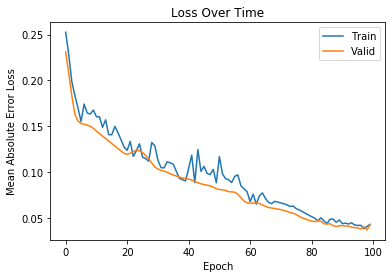

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [22]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

In [23]:
encoder_input_data = normalized_seasons[0:-1]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-1]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

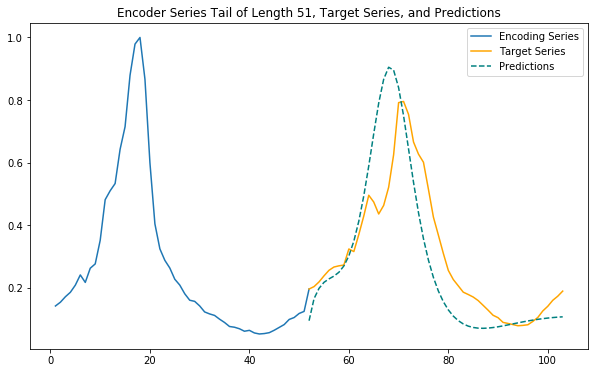

In [24]:
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data[sample_ind:sample_ind+1] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:].reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series
preds= predict_and_plot(encoder_input_data, decoder_target_data, 13)

This looks much better! How does it compare to previous predictions?

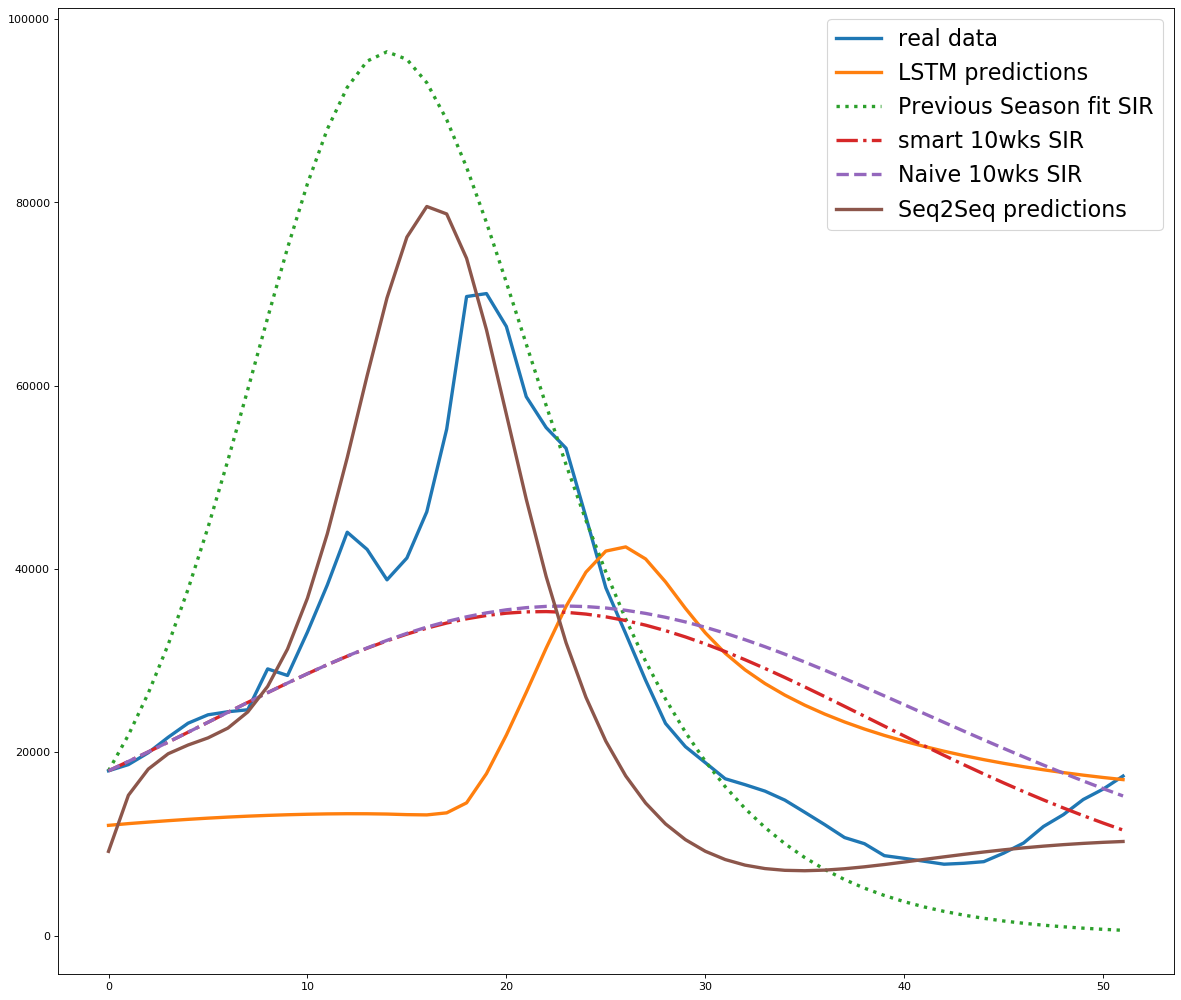

In [25]:
unscaled2 =preds*(seasons.max()-seasons.min())+seasons.min()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(seasons[-1], label='real data', linewidth =3)
plt.plot(unscaled, label='LSTM predictions', linewidth =3)
plt.plot(I, label="Previous Season fit SIR", linestyle=':', linewidth =3)
plt.plot(I2, label="smart 10wks SIR", linestyle='-.', linewidth =3)
plt.plot(I3, label="Naive 10wks SIR", linestyle='--', linewidth =3)
plt.plot(unscaled2, label='Seq2Seq predictions', linestyle='-', linewidth =3)
plt.legend(prop={'size': 20})
plt.show()

In [26]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I2.max() - seasons[-1].max()))
print("Seq2Seq Predictions:",abs(unscaled2.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I2) - np.argmax(seasons[-1])))
print("Seq2Seq Predictions:",abs(np.argmax(unscaled2) - np.argmax(seasons[-1])))

Difference in Peak Value:
LSTM Predictions: 27646.726872302585
Best SIR Prediction: 34705.343451666995
Seq2Seq Predictions: 9502.650855720043

Difference in Peak Week:
LSTM Predictions: 7
Best SIR Prediction: 3
Seq2Seq Predictions: 3


The Seq2Seq predictions do significantly better than both SIR and LSTM on predicting the peak value of the epidemic. Furthermore, it does just as well on predicting the peak week as the SIR model.